https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_randomforest/Sklearn_on_SageMaker_end2end.ipynb

In [1]:
import os
import boto3
import re
import sagemaker
import pandas as pd
import json
import numpy as np
from sagemaker import get_execution_role
from sklearn.metrics import r2_score
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()

bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/bmeajg31'
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region, bucket)

In [2]:
data = pd.read_csv('s3://sagemakerbmeironia/sagemaker_input_data/data.csv', sep=';')
data.set_index('date_ws', inplace=True)

check_equal_df = False
while not check_equal_df:
    data_pre = data.copy()
    data.fillna(method='ffill', inplace=True)
    check_equal_df = data.equals(data_pre)

check_equal_df = False
while not check_equal_df:
    data_pre = data.copy()
    data.fillna(method='bfill', inplace=True)
    check_equal_df = data.equals(data_pre)
    
returns = np.log(data).diff()

market = returns.mean(axis=1)
market.iloc[0] = 1
market_cum = market.cumsum()
inputs = market_cum[:-1]
target = market_cum[1:]

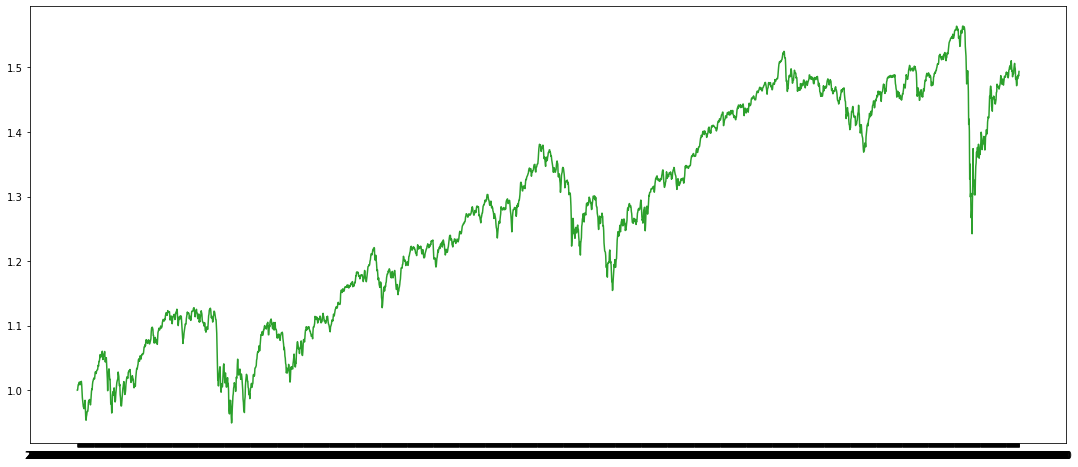

In [3]:
fig, ax1 = plt.subplots()
ax1.plot(inputs, color='tab:green')
fig.tight_layout()
fig.set_size_inches(18.5, 7, forward=True)
plt.show()

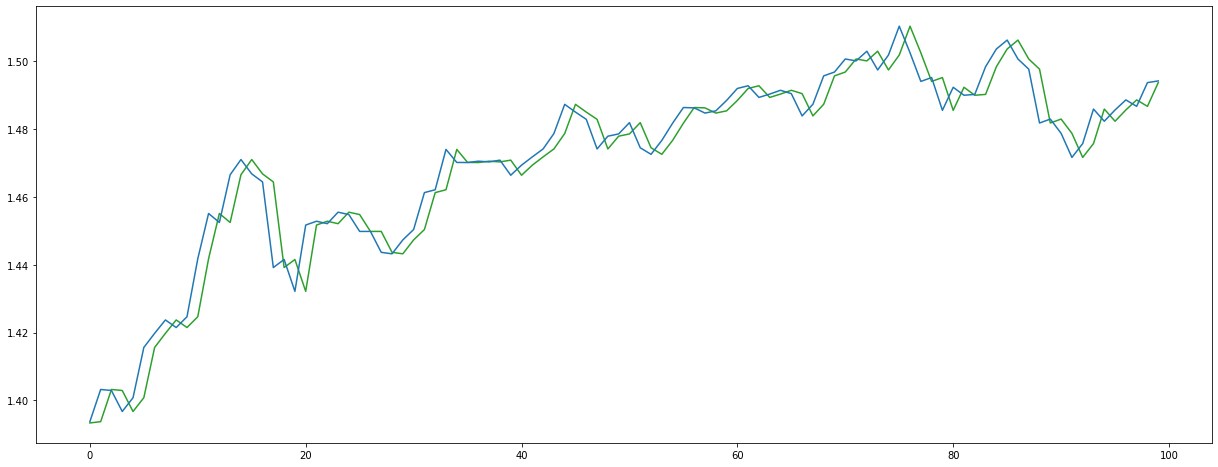

In [4]:
fig, ax1 = plt.subplots()
ax1.plot(inputs.tail(100).values, color='tab:green')
ax1.plot(target.tail(100).values, color='tab:blue')
fig.tight_layout()
fig.set_size_inches(18.5, 7, forward=True)
plt.show()

In [5]:
# Dividir en train, test y val y persistir

In [6]:
perc_train = 0.7
perc_test = 0.2

In [7]:
train_x, train_y = inputs.iloc[:int(len(inputs)*perc_train)] , target.iloc[:int(len(inputs)*perc_train)]
test_x, test_y = inputs.iloc[int(len(inputs)*perc_train):int(len(inputs)*(perc_train+perc_test))] , target.iloc[int(len(inputs)*perc_train):int(len(inputs)*(perc_train+perc_test))]
val_x, val_y = inputs.iloc[int(len(inputs)*(perc_train+perc_test)):] , target.iloc[int(len(inputs)*(perc_train+perc_test)):]

In [8]:
train_x.to_csv('train_x.csv', index=False)
train_y.to_csv('train_y.csv', index=False)
test_x.to_csv('test_x.csv', index=False)
test_y.to_csv('test_y.csv', index=False)

In [9]:
train_x_path = sess.upload_data(
    path='train_x.csv', bucket=bucket,
    key_prefix='sagemaker/sklearncontainer')

train_y_path = sess.upload_data(
    path='train_y.csv', bucket=bucket,
    key_prefix='sagemaker/sklearncontainer')

test_x_path = sess.upload_data(
    path='test_x.csv', bucket=bucket,
    key_prefix='sagemaker/sklearncontainer')

test_y_path = sess.upload_data(
    path='test_y.csv', bucket=bucket,
    key_prefix='sagemaker/sklearncontainer')

# Exportar script

In [10]:
%%writefile script.py

import argparse
import joblib
import json
import os
import pprint

import boto3
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import r2_score

import subprocess
import sys



# inference functions ---------------
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf



if __name__ =='__main__':
    
    subprocess.check_call([sys.executable, "-m", "pip", "install", "s3fs"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "fsspec"])
    

    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--x_train_file', type=str, default='train_x.csv')
    parser.add_argument('--y_train_file', type=str, default='train_y.csv')
    parser.add_argument('--x_test_file', type=str, default='test_x.csv')
    parser.add_argument('--y_test_file', type=str, default='test_y.csv')

    args, _ = parser.parse_known_args()

    if args.train == 'unused':
        print('reading data')
        x_train = pd.read_csv(args.x_train_file).values[:,0]
        y_train = pd.read_csv(args.y_train_file).values[:,0]
        x_test = pd.read_csv(args.x_test_file).values[:,0]
        y_test = pd.read_csv(args.y_test_file).values[:,0]
        
    else:
        print('reading data')
        x_train = pd.read_csv(os.path.join(args.train, args.x_train_file)).values[:,0]
        y_train = pd.read_csv(os.path.join(args.train, args.y_train_file)).values[:,0]
        x_test = pd.read_csv(os.path.join(args.test, args.x_test_file)).values[:,0]
        y_test = pd.read_csv(os.path.join(args.test, args.y_test_file)).values[:,0]


    print('training model')
    model = IsotonicRegression(increasing='auto', out_of_bounds='clip')
    model.fit(x_train, y_train)

    # print abs error
    print('validating model')
    pred = model.predict(x_test)
    score = r2_score(y_test, pred)
    print(f'R2 score of {score}')

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print('model persisted at ' + path)

Writing script.py


# Test local

In [11]:
! python script.py --model-dir ./ \
                   --train ./ \
                   --test ./ \

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
extracting arguments
reading data
training model
validating model
R2 score of -1.4122399112073758
model persisted at ./model.joblib


# Entrenamiento

In [12]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = '0.23-1'

sklearn_estimator = SKLearn(
    entry_point='script.py',
    role = get_execution_role(),
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    framework_version=FRAMEWORK_VERSION,
    base_job_name='rf-scikit',
    hyperparameters = {'train':'unused',
                       'test':'unused',
                       'x_train_file': train_x_path,
                       'y_train_file': train_y_path,
                       'x_test_file': test_x_path,
                       'y_test_file': test_y_path})

In [13]:
sklearn_estimator.fit( wait=False)

In [14]:
sklearn_estimator.latest_training_job.wait()
artifact = sm_boto3.describe_training_job(
    TrainingJobName=sklearn_estimator.latest_training_job.name)['ModelArtifacts']['S3ModelArtifacts']

print('Model artifact persisted at ' + artifact)

2020-10-30 19:54:38 Starting - Starting the training job...
2020-10-30 19:54:40 Starting - Launching requested ML instances......
2020-10-30 19:56:02 Starting - Preparing the instances for training......
2020-10-30 19:56:59 Downloading - Downloading input data...
2020-10-30 19:57:27 Training - Downloading the training image.....2020-10-30 19:58:13,079 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-10-30 19:58:13,081 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-30 19:58:13,090 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-10-30 19:58:13,391 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-30 19:58:16,470 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-30 19:58:16,481 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-30 19:58:16,490 s

# Desplegar endpoint

In [15]:
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
    model_data=artifact,
    role=get_execution_role(),
    entry_point='script.py',
    framework_version=FRAMEWORK_VERSION)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [16]:
predictor = model.deploy(
    instance_type='ml.t2.medium',
    initial_instance_count=1)

-----------------------!

#  Interactuar con endpoint

In [17]:
runtime = boto3.client('sagemaker-runtime')

In [18]:
response = runtime.invoke_endpoint(
    EndpointName=predictor.endpoint,
    Body=val_x.to_csv(header=False, index=False).encode('utf-8'),
    ContentType='text/csv')

In [19]:
pred = json.loads(response['Body'].read().decode())

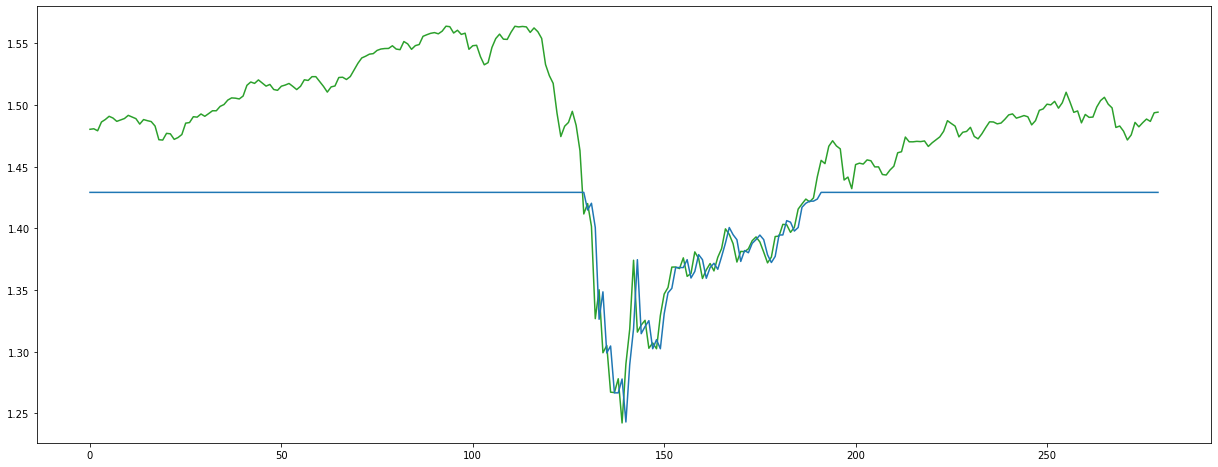

In [20]:
fig, ax1 = plt.subplots()
ax1.plot(val_y.values, color='tab:green')
ax1.plot(pred, color='tab:blue')
fig.tight_layout()
fig.set_size_inches(18.5, 7, forward=True)
plt.show()

In [21]:
r2_score(val_y.values, pred)

-0.12299566146498608

# Borrar endpoint

In [42]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint)

{'ResponseMetadata': {'RequestId': 'c6f495c1-fe99-42f9-821b-62e486d2d2c4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c6f495c1-fe99-42f9-821b-62e486d2d2c4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 30 Oct 2020 10:59:08 GMT'},
  'RetryAttempts': 0}}